Generate gaussian data
===

Generate two balanced distributions with n poinds in dimension d

In [1]:
import torch


# dimension d and number of samples n
d = 2
n = 1000

# distribution parameters (two distributions, distribution 0 and distribution 1)
mu_0 = torch.zeros(n, d)
mu_1 = torch.zeros(n, d)
mu_1[:, 0] = 5
sigma = 1

# generate x with distribution 0 (corresponding to labels -1)
x_0 = torch.normal(0, 1, size=(n, d)) + mu_0
t_0 = - torch.ones(n)

# generate x with distribution 1 (corresponding to labels +1)
x_1 = torch.normal(0, 1, size=(n, d)) + mu_1
t_1 = torch.ones(n)

# stack them 
X = torch.cat((x_0, x_1), dim=0)
T = torch.cat((t_0, t_1), dim=0)

# generate y 
x_0.size(), x_1.size(), t_0.size(), t_1.size(), X.size(), T.size()

(torch.Size([1000, 2]),
 torch.Size([1000, 2]),
 torch.Size([1000]),
 torch.Size([1000]),
 torch.Size([2000, 2]),
 torch.Size([2000]))

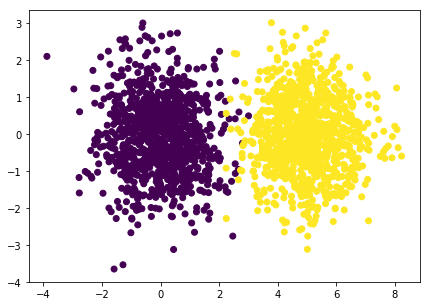

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], c=T)
plt.show()

Code loss function and its gradient
===

With formulas avec w et bias

In [3]:
from scipy.special import expit


def loss_function(w, b, X, T):
    margin = T * (torch.mm(X, w).squeeze() - b)
    return torch.mean(torch.log(1 + torch.exp(-margin)))

def gradient(w, b, X, T):
    margin = T * (torch.mm(X, w).squeeze() - b)
    coef = expit(- margin)
    return torch.mean((coef * T).reshape(-1, 1) * X, axis=0), torch.mean(coef * T)

Gradcheck the gradient
====
We use finite difference approximations to check that
```loss_function(w + h, b, X, T) - loss_function(w - h, b, X, T)) / 2h```

is close to the gradient
```gradient(w, b, X, T)```
 __per coordinate__

In [4]:
import numpy as np

# generate random w and b parameters to test on them 
w = torch.rand(d, 1)
b = torch.rand(1)

# compute approximation of the gradient along direction i
def finite_differences(w, b, X, T, h, i):
    d = w.size(0)
    H = torch.zeros(d, 1)
    H[i] = h
    return (loss_function(w + H, b, X, T) - loss_function(w - H, b, X, T)) / (2 * h)

# gradcheck for given h at a given coordinate i
i = 1
h = 1e-5

# why do we use double()?
finite_differences(w.double(), b.double(), X.double(), T, h, i) + gradient(w.double(), b.double(), X.double(), T)[0][i]

tensor(-3.4213e-09, dtype=torch.float64)

Pytorch version
===
With nn.Modules

In [5]:
import torch.nn as nn


# define a linear layer (fully conected)
model = nn.Linear(d, 1)

# this is the logistic regression loss
loss = nn.BCEWithLogitsLoss()

# we recover the Y's that are in {0, 1} from the T's that are in {-1, 1}
Y = (T + 1) / 2

# define an optimizer that will do the gradient steps
sgd = torch.optim.SGD(model.parameters(), 1)

# training loop 
L = []
for step in range(2000):
    l_ = loss(model(X)[:,0], Y) # 1: forward
    L.append(l_.item())         # 1bis: save loss
    sgd.zero_grad()             # 2: zero grad so that the gradients are not accumulated
    l_.backward()               # 2: backward
    sgd.step()                  # 3: gradient step 

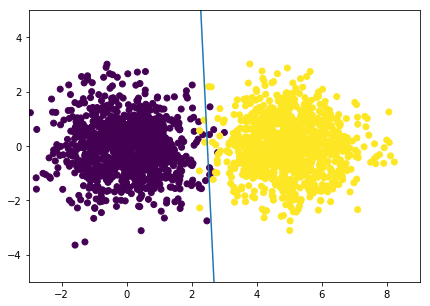

In [6]:
# how to recover the hyperplane from the model?
new_w = model.weight.data
new_b = model.bias.data
points = torch.linspace(-10, 10, 100)
hyperplane = -new_w[0, 0] / new_w[0, 1] * points - new_b / new_w[0, 1]

# plot the hyperplane and see that it does separate well the data
plt.figure(figsize=(7, 5))
plt.plot(points, hyperplane)
plt.xlim([-3, 9])
plt.ylim([-5, 5])
plt.scatter(X[:, 0], X[:, 1], c=T)
plt.show()

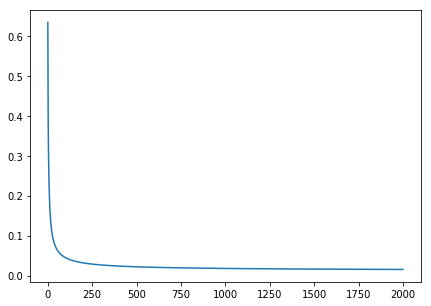

In [7]:
# regular plot 

plt.figure(figsize=(7, 5))
plt.plot(L)
plt.show()

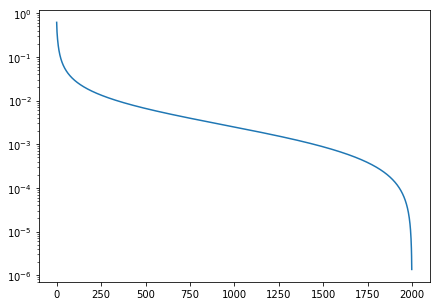

In [8]:
import numpy as np


# plot in log scale 
plt.figure(figsize=(7, 5))
plt.semilogy((np.array(L)-L[-1])[:-1])
plt.show()

Are PyTorch loss and gradient the same as the exact formulas?
===

In [9]:
# define a linear layer (fully conected)
model = nn.Linear(d, 1)

# this is the logistic regression loss
loss = nn.BCEWithLogitsLoss()

# we recover the Y's that are in {0, 1} from the T's that are in {-1, 1}
Y = (T + 1) / 2

model.zero_grad()
l_ = loss(model(X)[:,0], Y) 
l_.backward()      

In [10]:
# same losses
l_, loss_function(model.weight.data.t(), -model.bias.data, X, T)

(tensor(0.3927, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 tensor(0.3927))

In [11]:
# same gradients
model.weight.grad, gradient(model.weight.data.t(), -model.bias.data, X, T)[0]

(tensor([[-0.3878, -0.0741]]), tensor([0.3878, 0.0741]))